# How to use the Irspec2d script

The test data is in the `testdata` folder.  
It's for the DAR molecule calculated with a def2-TZVP basis set and the b3-lyp functional.  
The hetero-hydrogen atoms were deuterated and its calculated in D2O using COSMO.

In [1]:
import sys
sys.path.append('/home/julia/2d-ir-spectroscopy/src')
sys.path.append('/home/julia/2d-ir-spectroscopy/src/Irspec2d/')

import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import LinearSegmentedColormap

colors = ["#70002d","#b00046", "#c0336b", "#ffffff", "#3399c3", "#005374", "#00364c"]
ccmap1 = LinearSegmentedColormap.from_list("mycmap", colors)
ccmap1_r = LinearSegmentedColormap.from_list("mycmap", colors[::-1])

from Irspec2d import * 

In [2]:
# load data

VCI_freq = np.load('testdata/VCI_frequencies.npy')
VCI_dipo = np.load('testdata/VCI_dipolemoments.npy')
VCI_ints = np.load('testdata/VCI_intensities.npy')

VCI_freq_h = np.load('testdata/VCI_frequencies_harm.npy')
VCI_dipo_h = np.load('testdata/VCI_dipolemoments_harm.npy')
VCI_ints_h = np.load('testdata/VCI_intensities_harm.npy')

print(VCI_dipo.shape)

EXC_cmat = np.load('testdata/Exciton_cmat_lm.npy')
EXC_dipo = np.load('testdata/Exciton_dipolemoments_lm.npy')

(6, 6, 1, 3)


-----------------
## 1D Spectra

In order to plot 1D spectra I added a few (static) methods to the spectra class.

```python
def get_1d_spectrum(xmin,xmax,freqs,ints,steps=5000,halfwidth=5,ftype='gauss'):
    (...)
    return x,y
```

This computes the x and y values for the spectra. One can chose between gaussian and lorentzian functions.

If the intensities are not given, one can use 
```python
def calc_trans2int():
    (...)
    return intenmat
```
from the Calc2dir_base class in order to calculate the intensity matrix from the given transition dipole moment matrix.  
Use it like this:
```python
calc_ints = Calc2dir_base(freqs, dips).calc_trans2int()
```

In [3]:
x_1d_g,y_1d_g = spectra.get_1d_spectrum(2000,2200,VCI_freq[0],VCI_ints[0],ftype='gauss')
y_1d_g = y_1d_g/y_1d_g.max()
x_1d_l,y_1d_l = spectra.get_1d_spectrum(2000,2200,VCI_freq[0],VCI_ints[0],ftype='lorentz')
y_1d_l = y_1d_l/y_1d_l.max()

x_1d_g_h,y_1d_g_h = spectra.get_1d_spectrum(2000,2200,VCI_freq_h[0],VCI_ints_h[0],ftype='gauss')
y_1d_g_h = y_1d_g_h/y_1d_g_h.max()
x_1d_l_h,y_1d_l_h = spectra.get_1d_spectrum(2000,2200,VCI_freq_h[0],VCI_ints_h[0],ftype='lorentz')
y_1d_l_h = y_1d_l_h/y_1d_l_h.max()

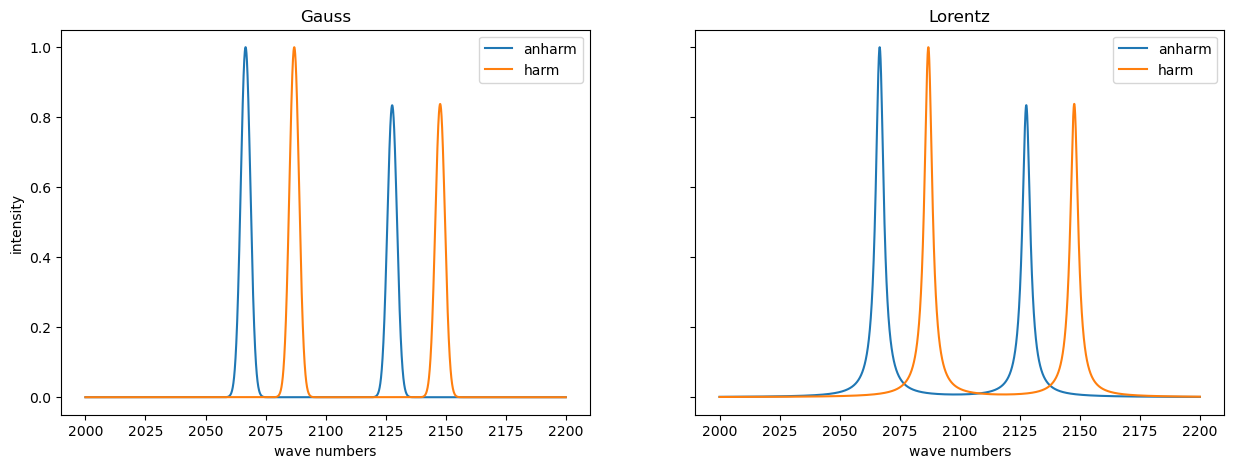

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,5))

ax1.plot(x_1d_g, y_1d_g,label='anharm')
ax2.plot(x_1d_l, y_1d_l,label='anharm')

ax1.plot(x_1d_g_h, y_1d_g_h,label='harm')
ax2.plot(x_1d_l_h, y_1d_l_h,label='harm')

ax1.set_title('Gauss')
ax2.set_title('Lorentz')

ax1.set_ylabel('intensity')
ax1.set_xlabel('wave numbers')
ax2.set_xlabel('wave numbers')

ax1.legend()
ax2.legend()

plt.show()

-------------------
## Frequency Domain

There are three processes that can happen: Excited State Absorption, Stimulated Emission and Ground State Bleach.  
Each of them can be calculated by a function as tuples:
```python
def calc_excitation(self,intmat):
    (...)
    return (exc_x, exc_y, exc_i)

def calc_stimulatedemission(self,intmat):
    (...)
    return (emi_x, emi_y, emi_i)

def calc_bleaching(self,intmat):
    (...)
    return (ble_x, ble_y, ble_i)
```
In order to compute all of them at once, there is
```python
def calc_all_2d_process(self):
    (...)
    return exc, ste, ble
```

This leads to x- and y-coordinates of the differnt peaks with their respective intensities.  

In [5]:
freqdom = frequencydomain(VCI_freq[0],VCI_dipo,T2=0.3)
exc,emi,ble = freqdom.calc_all_2d_process()

Prints all output (default). To suppress printed output use frequencydomain(freqs,dipoles,print_output=False).
Set the number of time points (n_t) to 256 (default value).
Set the time step length (dt) to 0.25 ps (default value).
Set the dephasing time (T2) to 0.3 ps.
Set the polarization (pol) to ZZZZ (default).
Set the polarization angles (pol_list) to [0, 0, 0, 0] (calculated default).


Now, there are functions fittet on top of these peaks - analogous to the 1D spectra seen before one can chose between gauss and lorentz functions.  
They can also be normalized, so that the highest peak has the intensity = 1.
```python
def _get_2d_spectrum(xmin,xmax,steps=2000,halfwidth=5,ftype='lorentz'):
    (...)
    return x, z
```

In [6]:
w, S = freqdom.get_2d_spectrum()
S = S/S.max()

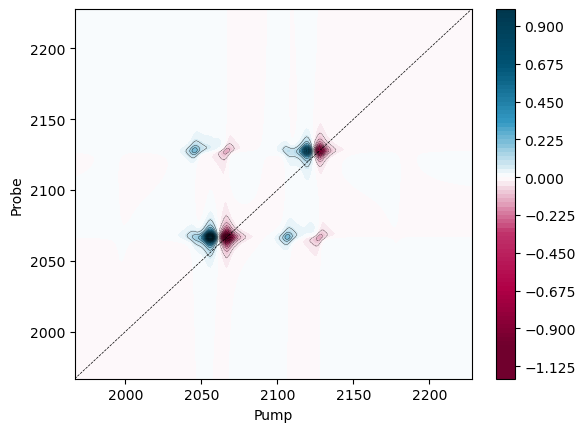

In [7]:
plt.plot([w.min(),w.max()], [w.min(),w.max()], ls="--", c="0", linewidth=0.5)

im1 = plt.contourf(w,w,S, 100, alpha=1, cmap=ccmap1, vmax=1, vmin=-1)
plt.contour(w,w,S,spectra.set_line_spacing(abs(S).max(),20),colors='k',linewidths=.25)

plt.ylabel('Probe')
plt.xlabel('Pump')

plt.colorbar(im1)
plt.show()

In [8]:
dim = 500
min_fd = 2035
max_fd = 2150

x_2d_g, z_2d_g = freqdom._get_2d_spectrum(min_fd, max_fd, steps=dim, gamma=2.5, ftype='gauss')
z_2d_g = z_2d_g/z_2d_g.max()

x_2d_l, z_2d_l = freqdom._get_2d_spectrum(min_fd, max_fd, steps=dim, gamma=2.5, ftype='lorentz')
z_2d_l = z_2d_l/z_2d_l.max()

In order to plot the lines beautifully, another function
```python
def set_line_spacing(maximum,number):
```
is used. This takes in the maximum value of an array and the number of contour lines one would like to have.

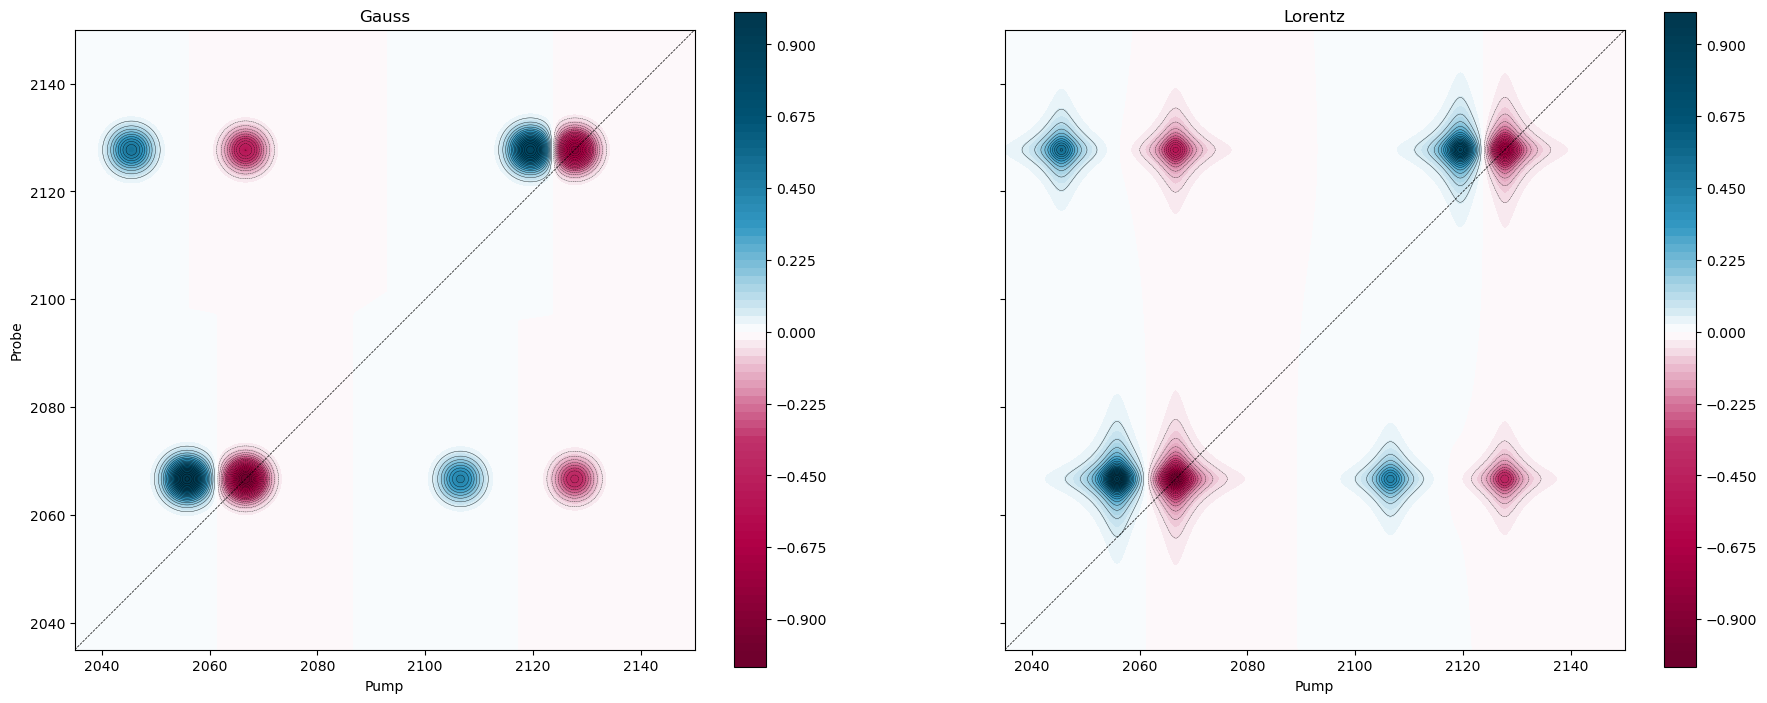

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(22,10))

ax1.plot([min_fd,max_fd], [min_fd,max_fd], ls="--", c="0", linewidth=0.5)
ax2.plot([min_fd,max_fd], [min_fd,max_fd], ls="--", c="0", linewidth=0.5)

im1 = ax1.contourf(x_2d_g,x_2d_g,z_2d_g, 100, alpha=1, cmap=ccmap1, vmax=1, vmin=-1)
im2 = ax2.contourf(x_2d_l,x_2d_l,z_2d_l, 100, alpha=1, cmap=ccmap1, vmax=1, vmin=-1)

ax1.contour(x_2d_g,x_2d_g,z_2d_g,spectra.set_line_spacing(abs(z_2d_g).max(),20),colors='k',linewidths=.25)
ax2.contour(x_2d_l,x_2d_l,z_2d_l,spectra.set_line_spacing(abs(z_2d_l).max(),20),colors='k',linewidths=.25)

ax1.set_title('Gauss')
ax2.set_title('Lorentz')

ax1.set_ylabel('Probe')
ax1.set_xlabel('Pump')
ax2.set_xlabel('Pump')

ax1.set_aspect(1./ax1.get_data_ratio())
ax2.set_aspect(1./ax2.get_data_ratio())

fig.colorbar(im1, ax=ax1, shrink=0.85)
fig.colorbar(im2, ax=ax2, shrink=0.85)

plt.show()

----------
## Time Domain

The time domain calculation needs more parameters:
- $n_t$ (n_t) : number of time points (grid)
- $\Delta t$ (dt) : spacing between time points
- $T_2$ (T2) : dephasing time
- $t2$ (t2) : time between laser pulses
- pol : polarization condition, e.g. 'ZZZZ' or 'ZZXX'
- pol_list : polarization condition angles, e.g. [0,0,0,0] or [0,0,90,90]
- omega_off : roughly the median of fundamental frequencies

If none are given, the calculation automatically choses standard values.

```python
timedomain(VCI_freq,VCI_dipo,n_t=n_t,dt=dt,T2=T2,pol=pol,pol_list=pol_list,omega_off=omega_off,print_output=True)
```

All calculations can also be done for the harmonic spectra! 

In [10]:
R, ticks = timedomain(VCI_freq,VCI_dipo).get_absorptive_spectrum()
R = R/R.max()

Prints all output (default). To suppress printed output use timedomain(freqs,dipoles,print_output=False).
Set the number of time points (n_t) to 128 (default value).
Set the time step length (dt) to 0.25 ps (default value).
Set the dephasing time (T2) to 2 ps (default value).
Set the population time (t2) to 0 ps (default value).
Set the polarization (pol) to ZZZZ (default).
Set the polarization angles (pol_list) to [0, 0, 0, 0] (calculated default).
Set the omega offset value (omega_off) to 2097 (calculated default).


In [11]:
R_ZZXX, ticks_ZZXX = timedomain(VCI_freq,VCI_dipo,pol='ZZXX').get_absorptive_spectrum()
R_ZZXX = R_ZZXX/R_ZZXX.max()

Prints all output (default). To suppress printed output use timedomain(freqs,dipoles,print_output=False).
Set the number of time points (n_t) to 128 (default value).
Set the time step length (dt) to 0.25 ps (default value).
Set the dephasing time (T2) to 2 ps (default value).
Set the population time (t2) to 0 ps (default value).
Set the polarization (pol) to ZZXX .
Set the polarization angles (pol_list) to [0, 0, 90, 90] (calculated default).
Set the omega offset value (omega_off) to 2097 (calculated default).


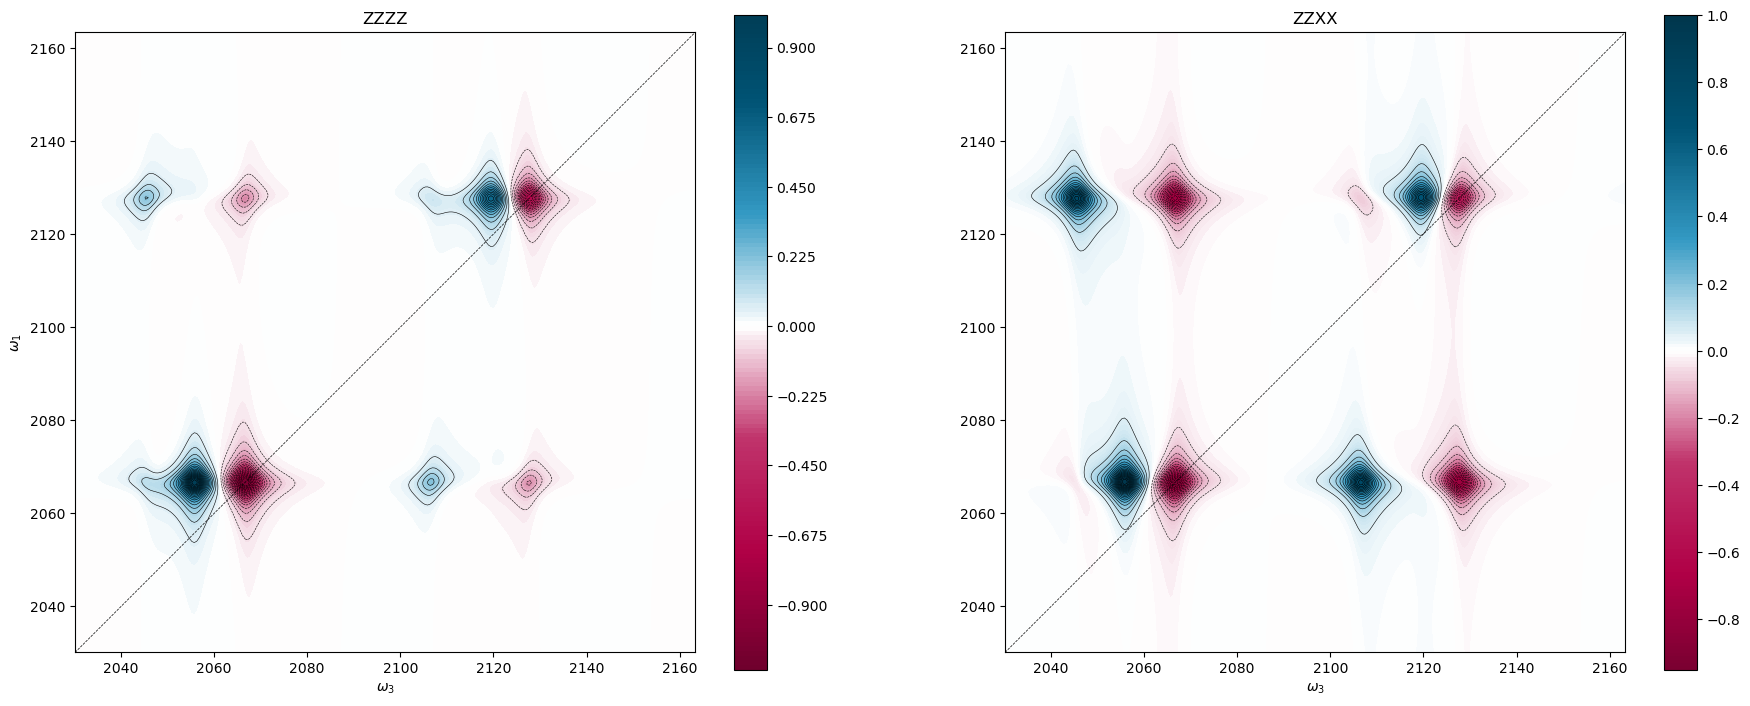

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,10))

ax1.plot([min(ticks),max(ticks)], [min(ticks),max(ticks)], ls="--", c="0", linewidth=0.5)
ax2.plot([min(ticks_ZZXX),max(ticks_ZZXX)], [min(ticks_ZZXX),max(ticks_ZZXX)], ls="--", c="0", linewidth=0.5)

im1 = ax1.contourf(ticks, ticks, R, 200, alpha=1, cmap=ccmap1, vmax=abs(R).max(), vmin=-abs(R).max())
im2 = ax2.contourf(ticks_ZZXX, ticks_ZZXX, R_ZZXX, 200, alpha=1, cmap=ccmap1, vmax=abs(R_ZZXX).max(), vmin=-abs(R_ZZXX).max())

ax1.contour(ticks, ticks, R, spectra.set_line_spacing(abs(R.max()),20), colors='k', linewidths=.4)
ax2.contour(ticks_ZZXX, ticks_ZZXX, R_ZZXX, spectra.set_line_spacing(abs(R_ZZXX).max(),20), colors='k', linewidths=.4)

ax1.set_title('ZZZZ')
ax2.set_title('ZZXX')

ax1.set_ylabel('$\\omega_1$')
ax1.set_xlabel('$\\omega_3$')
ax2.set_xlabel('$\\omega_3$')

ax1.set_xlim(min(ticks),max(ticks))
ax2.set_xlim(min(ticks_ZZXX),max(ticks_ZZXX))

ax1.set_ylim(min(ticks),max(ticks))
ax2.set_ylim(min(ticks_ZZXX),max(ticks_ZZXX))

ax1.set_aspect(1./ax1.get_data_ratio())
ax2.set_aspect(1./ax2.get_data_ratio())

fig.colorbar(im1, ax=ax1, shrink=0.85)
fig.colorbar(im2, ax=ax2, shrink=0.85)

plt.show()

------------
## Exciton Model 

The exciton model is used to compute the frequency matrix and the transition dipole moment matrix from harmonic calculations using an empirical parameter for the anharmonicity. 

In [13]:
EX_freqs, EX_dipoles = excitonmodel(EXC_cmat, EXC_dipo).get_nm_freqs_dipolmat(20)

In [14]:
R_EX, ticks_EX = timedomain(EX_freqs,EX_dipoles).get_absorptive_spectrum()
R_EX = R_EX/R_EX.max()

freqdom_EX = frequencydomain(EX_freqs, EX_dipoles, T2=0.35)
x_EX_l, z_EX_l_ = freqdom_EX.get_2d_spectrum()
z_EX_l = z_EX_l_/z_EX_l_.max()

Prints all output (default). To suppress printed output use timedomain(freqs,dipoles,print_output=False).
Set the number of time points (n_t) to 128 (default value).
Set the time step length (dt) to 0.25 ps (default value).
Set the dephasing time (T2) to 2 ps (default value).
Set the population time (t2) to 0 ps (default value).
Set the polarization (pol) to ZZZZ (default).
Set the polarization angles (pol_list) to [0, 0, 0, 0] (calculated default).
Set the omega offset value (omega_off) to 2097 (calculated default).
Prints all output (default). To suppress printed output use frequencydomain(freqs,dipoles,print_output=False).
Set the number of time points (n_t) to 256 (default value).
Set the time step length (dt) to 0.25 ps (default value).
Set the dephasing time (T2) to 0.35 ps.
Set the polarization (pol) to ZZZZ (default).
Set the polarization angles (pol_list) to [0, 0, 0, 0] (calculated default).


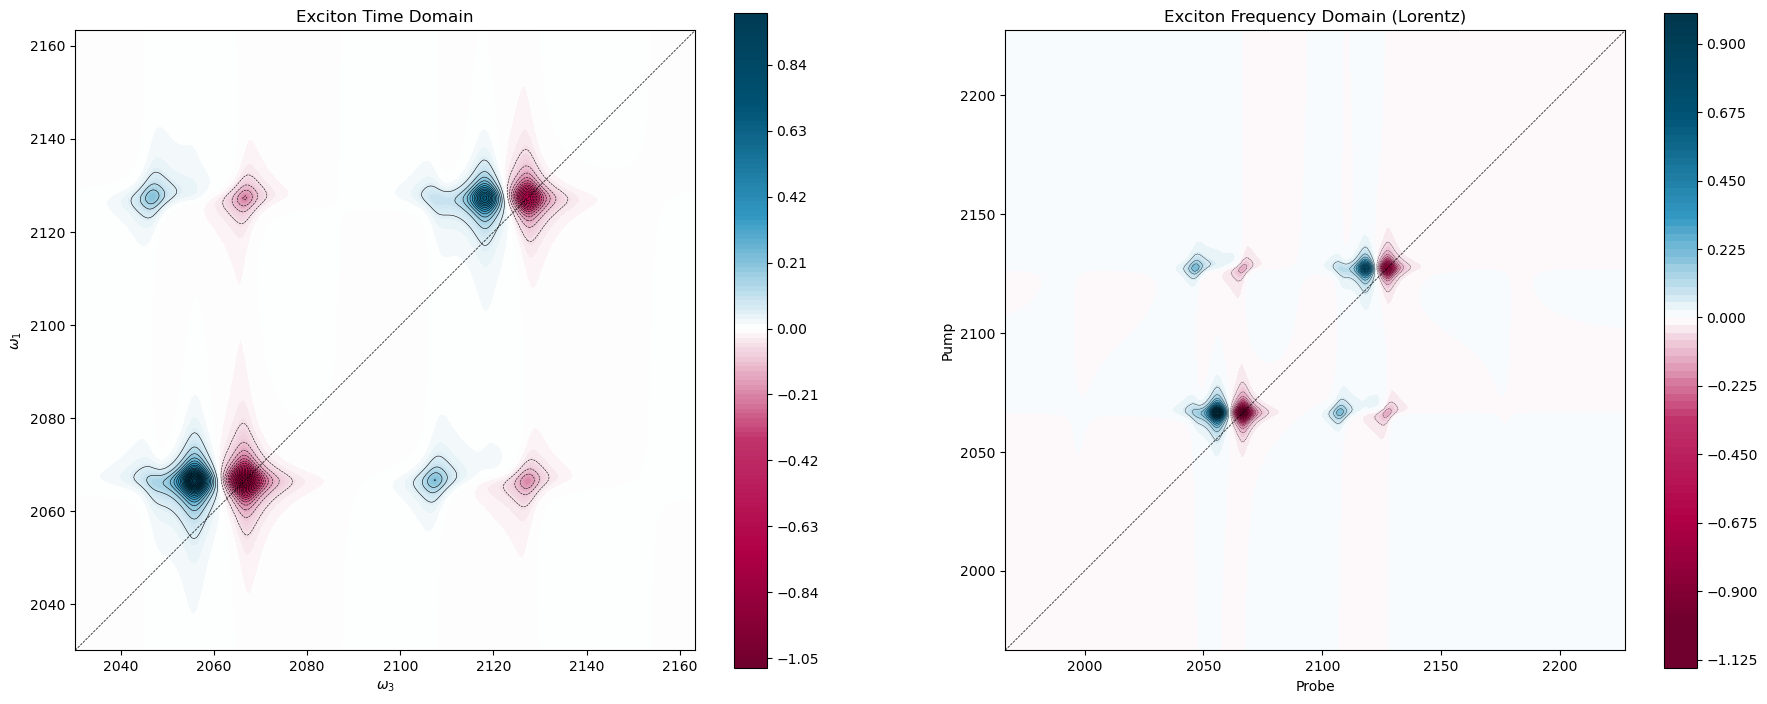

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,10))

ax1.plot([min(ticks_EX),max(ticks_EX)], [min(ticks_EX),max(ticks_EX)], ls="--", c="0", linewidth=0.5)
im1 = ax1.contourf(ticks_EX, ticks_EX, R_EX, 200, alpha=1, cmap=ccmap1, vmax=abs(R_EX).max(), vmin=-abs(R_EX).max())
ax1.contour(ticks_EX, ticks_EX, R_EX, spectra.set_line_spacing(abs(R_EX).max(),20), colors='k', linewidths=.4)

ax1.set_title('Exciton Time Domain')
ax1.set_ylabel('$\\omega_1$')
ax1.set_xlabel('$\\omega_3$')
ax1.set_xlim(min(ticks_EX),max(ticks_EX))
ax1.set_ylim(min(ticks_EX),max(ticks_EX))
ax1.set_aspect(1./ax1.get_data_ratio())
fig.colorbar(im1, ax=ax1, shrink=0.85)


ax2.set_title('Exciton Frequency Domain (Lorentz)')
ax2.plot([x_EX_l.min(),x_EX_l.max()], [x_EX_l.min(),x_EX_l.max()], ls="--", c="0", linewidth=0.5)
im2 = ax2.contourf(x_EX_l,x_EX_l,z_EX_l, 100, alpha=1, cmap=ccmap1, vmax=1, vmin=-1)
ax2.contour(x_EX_l,x_EX_l,z_EX_l,spectra.set_line_spacing(abs(z_EX_l).max(),20),colors='k',linewidths=.25)
ax2.set_ylabel('Pump')
ax2.set_xlabel('Probe')
ax2.set_xlim(x_EX_l.min(),x_EX_l.max())
ax2.set_ylim(x_EX_l.min(),x_EX_l.max())
ax2.set_aspect(1./ax2.get_data_ratio())
fig.colorbar(im2, ax=ax2, shrink=0.85)

plt.show()